In [41]:
import os
home = os.path.expanduser("~")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
snscolors=sns.color_palette()
snscolors=np.tile(np.array(snscolors),(4,1))
import pickle
import gzip
import gc
import time
import importlib

import torch
torch.set_num_threads(2)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Common Definitions and import

In [42]:
import datafunctions as dfunc
import headingchange_models as hm
import modelfit_plotfns as pf

<module 'modelfit_plotfns_v2' from '/home/jacob/Dropbox/zfish/code/modelfit_plotfns_v2.py'>

In [11]:
datadir = '/media/jacob/JD_DATA/zfish/'
resultdir = 'savedresults/'

paramsavedir = resultdir+'modelfits/'

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

# immport combined quantiles
outfile = resultdir+'combinedquantiles.pkl'
[all_speedquantiles10, all_speedquantiles20, all_ndistquantiles, all_bdistquantiles] = pickle.load(open(outfile,'rb'))


FITTING TO INCLUDE:
* main will be:  ik, H set, no freezing, no really low speeds (because heading estimation is unreliable), 10 bins for speed, 10 bins for neighbor.
* cases will include:  ik/ikH/ijkHH/ik-Groupsonly, all/no_lowspd/nofreeze_nolowspd

In [4]:
modelnames = ['ik','ikH','ijkHH','ik-Groupsonly']
modelsels = [False,False,True,False]  # whether or not to fit 'j' and 'H2' functions
groupsels = [False,False,False,True]  # whether or not to only fit groups
holdHconst = [True,False,False,True]

# define number of bins
# this will only be used for the psel indices, so just define once

binscheme = 'A10'
if (binscheme=='A10') | (binscheme=='T10'):
    refmodel = hm.model_4_FiFjFkHH(sibins=10,sjbins=10,rnumbins=10)   
elif binscheme =='A':
    refmodel = hm.model_4_FiFjFkHH(sibins=20,sjbins=10,rnumbins=20)   

## 'constant input parameters for ik'
Hparamsel = np.tile(False,refmodel.numparams)
Hparamsel[refmodel.psel_Hatt_phi] = True
Hparamsel[refmodel.psel_Hatt_theta] = True
Hparamsel[refmodel.psel_Hali_phi] = True
Hparamsel[refmodel.psel_Hali_theta] = True
Hparamsel[refmodel.psel_Fatt_i] = True
Hparamsel[refmodel.psel_Fali_i] = True

speedcasenames = ['','-Nolowspd','-Nolowspd_Nofreeze']  # the actual list to iterate through

Lfitext = '-Lfit'
trialfitext = '-trialfit'


def speedsel(casename,inputs,data):
    if casename=='-Nolowspd':
        return data[(inputs[:,hm.ind_speedseli]==1) | (inputs[:,hm.ind_speedseli]==3)]
    elif casename=='Nofreeze':
        return data[(inputs[:,hm.ind_speedseli]==2) | (inputs[:,hm.ind_speedseli]==3)]
    elif casename=='-Nolowspd_Nofreeze':
        return data[inputs[:,hm.ind_speedseli]==3]
    else:
        return data

viewstep=50
nopt=250  # this is a maximum now
lossthreshold=1e-5
lr=1e-1
numfish=6

def getcombinedparams(hcsel,ext,iopostfix,prefix='alltreatmentfit'):
    postfix = '-Lfit' if prefix in treatments else ''
    name = prefix+'-'+('ik' if ext=='ikH' else ext)+'-hcsel'+str(hcsel)+iopostfix[:-4]+postfix
    [_,Afitparams] = pickle.load(open(paramsavedir+name+'.pkl','rb'))
    return Afitparams

In [58]:
# input-output
iopostfixes = ['-io1-'+binscheme+'-far10.pkl']  # the convention is used is that io1 includes all data, io10 subsamples to every 10th point, io50 subsamples to every 50th point
combined_iopostfixes = ['-io10-'+binscheme+'-far10.pkl']  # for importing starting fits, and functions to hold constant
combinedfitprefix = 'focustreatmentfit'


ionum=0
iopostfix = iopostfixes[ionum]
combined_iopostfix = combined_iopostfixes[ionum]
print('iopostfix:', iopostfix)
print('combined_iopostfix:', combined_iopostfix)

#  Other things to set
modelnum=0
fnum=0
print('model: ',modelnames[modelnum] )
print('speedsel case (none is include all data): ', speedcasenames[fnum])


hcselnames=['heading-fixed30','heading-fixed60','heading-adjusted30','heading-adjusted60','vector-fixed30','vector-fixed60','vector-adjusted30','vector-adjusted60']
hcseldescriptions = ['predict change in heading; all have delay of 30 frames', 'predict change in heading; all have delay of 60 frames',
                    'predict change in heading; WT has delay of 30 frames, others adjusted','predict change in heading; WT has delay of 60 frames, others adjusted',
                    'predict angle change of position vector; all have delay of 30 frames', 'predict angle change of position vector; all have delay of 60 frames',
                    'predict angle change of position vector; WT has delay of 30 frames, others adjusted','predict angle change of position vector; WT has delay of 60 frames, others adjusted'                    ]

print('\nhcsel values and descriptions')
print('\t','value','\t\t','shortname','\t\t','description')
for i in range(8):
    print('\t',i,'\t\t',hcselnames[i],'\t',hcseldescriptions[i])
print('\nResults shown in paper use hcsel=7: ',hcseldescriptions[7])

iopostfix: -io1-A10-far10.pkl
combined_iopostfix: -io10-A10-far10.pkl
model:  ik
speedsel case (none is include all data):  

hcsel values and descriptions
	 value 		 shortname 		 description
	 0 		 heading-fixed30 	 predict change in heading; all have delay of 30 frames
	 1 		 heading-fixed60 	 predict change in heading; all have delay of 60 frames
	 2 		 heading-adjusted30 	 predict change in heading; WT has delay of 30 frames, others adjusted
	 3 		 heading-adjusted60 	 predict change in heading; WT has delay of 60 frames, others adjusted
	 4 		 vector-fixed30 	 predict angle change of position vector; all have delay of 30 frames
	 5 		 vector-fixed60 	 predict angle change of position vector; all have delay of 60 frames
	 6 		 vector-adjusted30 	 predict angle change of position vector; WT has delay of 30 frames, others adjusted
	 7 		 vector-adjusted60 	 predict angle change of position vector; WT has delay of 60 frames, others adjusted

Results shown in paper use hcsel=7:  predic

# Combined fit, for base parameters

focustreatmentfit-ik-hcsel7-io50-A10-far10
Step  0 / 250 	Loss: tensor(0.6754)
Fraction all turn sign correct 0.633 .  Turns 20<th<160 deg: 0.669
Step  50 / 250 	Loss: tensor(0.6311)
Fraction all turn sign correct 0.64 .  Turns 20<th<160 deg: 0.672
Step  100 / 250 	Loss: tensor(0.6301)
Fraction all turn sign correct 0.641 .  Turns 20<th<160 deg: 0.673
Fraction all turn sign correct 0.641 .  Turns 20<th<160 deg: 0.673


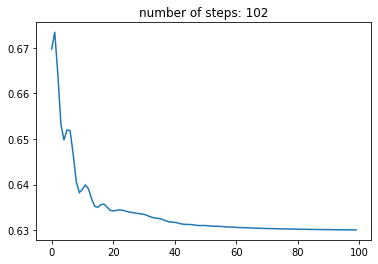

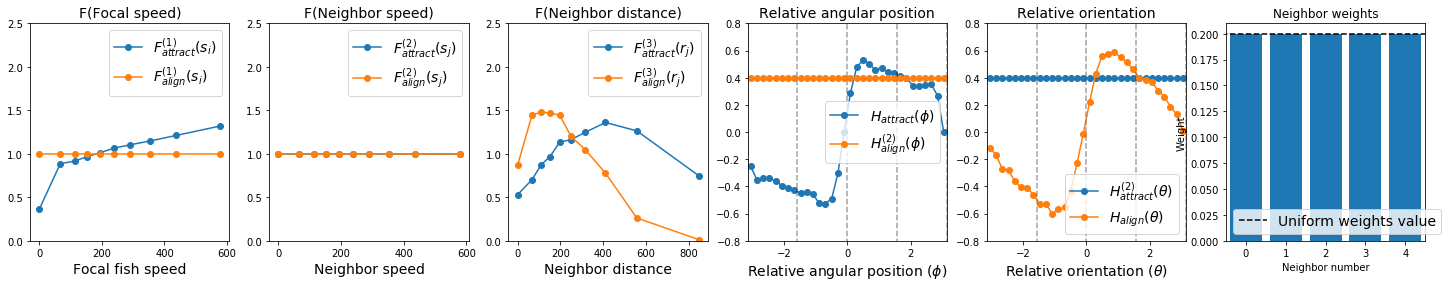

wrote to focustreatmentfit-ik-hcsel7-io50-A10-far10


In [6]:
# loop through to get the combined io
grid_inputs = []
grid_alloutputs = []
grid_alloutputsraw = []
for tnum in focustreatments:
    treatment = treatments[tnum]
    outfile = datadir+treatment+combined_iopostfix    
    inputs, alloutputs, alloutputsraw, _, _, _ = pickle.load(open(outfile,'rb'))
    grid_inputs.append(inputs)
    grid_alloutputs.append(alloutputs)
    grid_alloutputsraw.append(alloutputsraw)
inputs = np.concatenate(grid_inputs)
del grid_inputs
gc.collect()
alloutputs = [np.concatenate([g[hcsel] for g in grid_alloutputs]) for hcsel in range(len(grid_alloutputs[0]))]
del grid_alloutputs
gc.collect()    
alloutputsraw = [np.concatenate([g[hcsel] for g in grid_alloutputsraw]) for hcsel in range(len(grid_alloutputsraw[0]))]    
del grid_alloutputsraw
gc.collect()

hcsel = 7

ext, modelsel, groupsel = modelnames[modelnum], modelsels[modelnum], groupsels[modelnum]
Hsel = []  # dont hold any constant here, because there are the base fits

speedcase = speedcasenames[fnum]
ext = modelnames[modelnum]+speedcase            

outputs =  speedsel(speedcase,inputs,data=alloutputs[hcsel])
outputsraw = speedsel(speedcase,inputs,data=alloutputsraw[hcsel])

name = combinedfitprefix+'-'+ext+'-hcsel'+str(hcsel)+combined_iopostfix[:-4]
print(name)
#             if (not (os.path.isfile(paramsavedir+name+'.pkl'))) | (fnum==1):

if 'model' in locals():
    del model
model = hm.model_4_FiFjFkHH(sibins=refmodel.sibins,sjbins=refmodel.sjbins,rnumbins=refmodel.rnumbins,fiti=True,fitj=modelsel,fitk=True,
                            fitH2=modelsel,topofit=False,bfit=False,grouponly=groupsel)    

statusfn = lambda x: hm.printerrorfrac(model,x,speedsel(speedcase,inputs,inputs),outputs,outputsraw)
params, loss_history = hm.trainmodel(speedsel(speedcase,inputs,inputs),outputs,model,                                     
                                     viewstep=viewstep,lr=lr,nopt=nopt,viewfn=statusfn,lossthreshold=lossthreshold,holdconst=[])

statusfn(params)
pf.plotfit(model,params)
plt.show()

name = combinedfitprefix+'-'+ext+'-hcsel'+str(hcsel)+combined_iopostfix[:-4]
pickle.dump([name,params],open(paramsavedir+name+'.pkl','wb'))
print('wrote to',name)

# Separate fits

WT-ik-hcsel7-io10-A10-far10
Step  0 / 250 	Loss: tensor(0.6126)
Fraction all turn sign correct 0.665 .  Turns 20<th<160 deg: 0.714
Step  50 / 250 	Loss: tensor(0.6093)
Fraction all turn sign correct 0.666 .  Turns 20<th<160 deg: 0.714
Step  100 / 250 	Loss: tensor(0.6092)
Fraction all turn sign correct 0.666 .  Turns 20<th<160 deg: 0.714
Fraction all turn sign correct 0.666 .  Turns 20<th<160 deg: 0.714


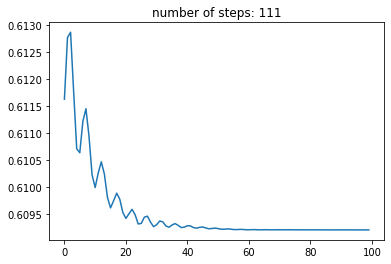

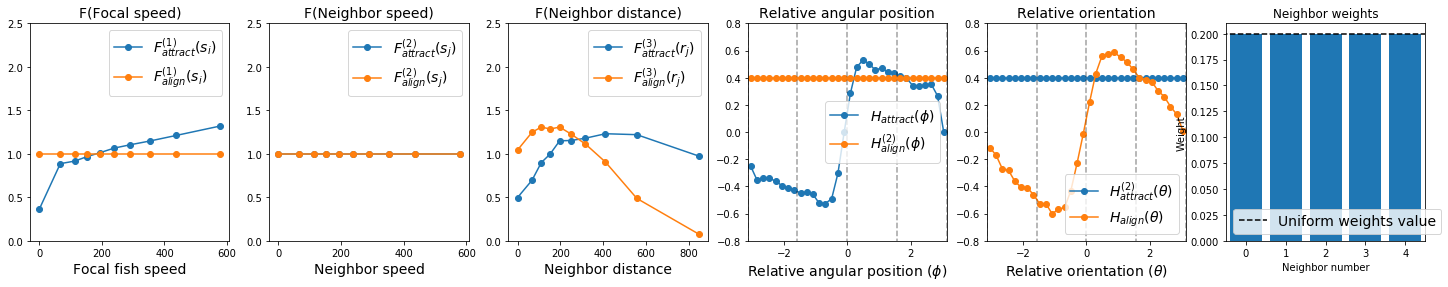

wrote to: WT-ik-hcsel7-io10-A10-far10-Lfit


In [20]:

hcsel=7

for tnum in focustreatments:
    treatment=treatments[tnum]   
    numtrials = allnumtrials[tnum]

    outfile = datadir+treatment+iopostfix
    base_inputs, alloutputs, alloutputsraw, _, _, _ = pickle.load(open(outfile,'rb'))

    ext, modelsel, groupsel = modelnames[modelnum], modelsels[modelnum], groupsels[modelnum]
    Hsel = (Hparamsel if holdHconst[modelnum] else [])            

    speedcase = speedcasenames[fnum]
    ext = modelnames[modelnum]+speedcase

    inputs = speedsel(speedcase,base_inputs,data=base_inputs)
    outputs =  speedsel(speedcase,base_inputs,data=alloutputs[hcsel])
    outputsraw = speedsel(speedcase,base_inputs,data=alloutputsraw[hcsel])

    # read in combined params
    combinedparams = getcombinedparams(hcsel,ext,combined_iopostfix,prefix=combinedfitprefix)

    print(treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4])
    ############################
    # Above loops/defs are identical to the hierarchical model fit loop.  below is different
    ############################

    for trial in range(-1,numtrials):
        if trial==-1:
            trialsel = np.tile(True,inputs.shape[0])
            Ltfitext = Lfitext
        else:
            trialsel = (inputs[:,hm.ind_trial]==trial)
            Ltfitext = trialfitext+str(trial)                    
        if 'model' in locals():
            del model
        model = hm.model_4_FiFjFkHH(sibins=refmodel.sibins,sjbins=refmodel.sjbins,rnumbins=refmodel.rnumbins,fiti=True,fitj=modelsel,fitk=True,
                                    fitH2=modelsel,topofit=False,bfit=False,grouponly=groupsel)    

        statusfn = lambda x: hm.printerrorfrac(model,x,inputs[trialsel],outputs[trialsel],outputsraw[trialsel])
        params, loss_history = hm.trainmodel(inputs[trialsel],outputs[trialsel],model,                                     
                                             viewstep=viewstep,lr=lr,nopt=nopt,viewfn=statusfn,lossthreshold=lossthreshold,
                                            inputinitialparams=combinedparams,holdconst=Hsel)                    

        statusfn(params)
        ###  COMMENT OUT THESE TWO LINES IF RUNNING MANY FITS AND DON'T WANT TO DISPLAY PLOTS
        pf.plotfit(model,params)
        plt.show()

        name = treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4]+Ltfitext
        pickle.dump([name,params], open(paramsavedir+name+'.pkl','wb'))   
        print('wrote to:', name)

# Import fits and save in compact form

In [24]:
numhcsel=8
def getparams(iopostfixes,modelnames,Lfitext,trialfitext,gettrial=True,speedcasenames=['']):
    numparams=refmodel.numparams
    # store treatment-only fit here:
    treatment_params = np.zeros((len(iopostfixes),len(modelnames),len(speedcasenames),numhcsel,numtreatments,numparams)) 
    # store trial-only fit here
    treatment_allparams = dfunc.initarray([len(iopostfixes),len(modelnames),len(speedcasenames),numhcsel,numtreatments])

    for tnum in range(numtreatments):
        treatment=treatments[tnum]   
        numtrials = allnumtrials[tnum]

        for ionum in range(len(iopostfixes)):
            iopostfix = iopostfixes[ionum]

            for modelnum in range(len(modelnames)):
                ext = modelnames[modelnum]

                for hcsel in range(numhcsel):
                    for fnum in range(len(speedcasenames)):
                        speedcase = speedcasenames[fnum]
                        ext = modelnames[modelnum]+speedcase
                        name = treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4]+Lfitext     
                        filename = paramsavedir+name+'.pkl'
                        if os.path.isfile(filename):
                            _,params = pickle.load(open(filename,'rb'))
                            treatment_params[ionum,modelnum,fnum,hcsel,tnum] = params[0:numparams]
                            allparams=params[0:numparams]
                        else:
                            allparams=np.zeros(numparams)
                        if gettrial:
                            for trial in range(numtrials):
                                name = treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4]+trialfitext+str(trial)     
                                filename = paramsavedir+name+'.pkl'
                                if os.path.isfile(filename):
                                    _,params = pickle.load(open(filename,'rb'))
                                    allparams = np.concatenate((allparams,params[0:numparams]))
                            treatment_allparams[ionum][modelnum][fnum][hcsel][tnum]= allparams

    return treatment_params, treatment_allparams

In [25]:
outfile = 'fits-hcsel8.pklz'

## NOTE:  NEED TO RUN THE CODE AT THE TOP, BEFORE THE FITS, FIRST

treatment_params,treatment_allparams = getparams(iopostfixes,modelnames,Lfitext,trialfitext,speedcasenames=speedcasenames)

pickle.dump([treatment_params,treatment_allparams,[Lfitext,trialfitext],iopostfixes,modelnames,modelsels,groupsels,speedcasenames],
           gzip.open(resultdir+outfile,'wb'))

WT-ik-hcsel7-io1-A10-far10-Lfit


(0, 4)

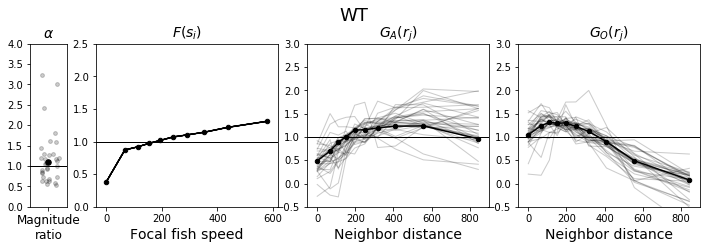

In [52]:
# view a single fit result
tnum=0  # for which line

hcsel = 7

treatment=treatments[tnum]   
numtrials = allnumtrials[tnum]
ext = modelnames[modelnum]
speedcase = speedcasenames[fnum]
ext = modelnames[modelnum]+speedcase
name = treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4]+Lfitext     
print(name)
filename = paramsavedir+name+'.pkl'       
_,params = pickle.load(open(filename,'rb'))
numparams = refmodel.numparams
allparams=params[0:numparams]
for trial in range(numtrials):
    name = treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4]+trialfitext+str(trial)     
    filename = paramsavedir+name+'.pkl'
    if os.path.isfile(filename):
        _,params = pickle.load(open(filename,'rb'))
        allparams = np.concatenate((allparams,params[0:numparams]))

plotfn = pf.plotfit_noangle  # can use plotfit, plotfit_simple, plotfit_noangle, plotfit_justdist
ax = pf.plotTfit(plotfn,refmodel,allparams, numtrials)
plt.suptitle(treatments[tnum],fontsize=18,y=1.05)
ax[0].set_ylim([0,4])  

# Loop through and calculate loss and fraction predicted correct

In [ ]:

numhcsel=8

treatment_errorsave = np.zeros((numtreatments,numhcsel,4))
trial_errorsave = dfunc.initarray([numtreatments,numhcsel])

for tnum in focustreatments:
    treatment=treatments[tnum]   
    numtrials = allnumtrials[tnum]

    outfile = datadir+treatment+iopostfix
    base_inputs, alloutputs, alloutputsraw, _, _, _ = pickle.load(open(outfile,'rb'))

    ext, modelsel, groupsel = modelnames[modelnum], modelsels[modelnum], groupsels[modelnum]


    speedcase = speedcasenames[fnum]
    ext = modelnames[modelnum]+speedcase
    allerror = dfunc.initarray([numhcsel])    
    for hcsel in [7]:
        inputs = speedsel(speedcase,base_inputs,data=base_inputs)
        outputs =  speedsel(speedcase,base_inputs,data=alloutputs[hcsel])
        outputsraw = speedsel(speedcase,base_inputs,data=alloutputsraw[hcsel])

        # read in combined params
#             combinedparams = getcombinedparams(hcsel,ext,combined_iopostfix,prefix=combinedfitprefix)
        combinedparams=0  # make sure not using this

        print(treatment+'-'+ext+'-hcsel'+str(hcsel)+iopostfix[:-4])
        ############################
        # Above loops/defs are identical to the hierarchical model fit loop.  below is different
        ############################

        for trial in range(-1,numtrials):
            if trial==-1:
                trialsel = np.tile(True,inputs.shape[0])
                Ltfitext = Lfitext
            else:
                trialsel = (inputs[:,hm.ind_trial]==trial)
                Ltfitext = trialfitext+str(trial)                    
            if 'model' in locals():
                del model
            model = hm.model_4_FiFjFkHH(sibins=refmodel.sibins,sjbins=refmodel.sjbins,rnumbins=refmodel.rnumbins,fiti=True,fitj=modelsel,fitk=True,
                                        fitH2=modelsel,topofit=False,bfit=False,grouponly=groupsel)    
            params = treatment_allparams[ionum][modelnum][fnum][hcsel][tnum][refmodel.numparams*(trial+1):refmodel.numparams*(trial+2)]

            allerror[hcsel].append(hm.geterror_all(model,params,inputs[trialsel],outputs[trialsel],outputsraw[trialsel]))

        treatment_errorsave[tnum,hcsel] = allerror[hcsel][0]
        trial_errorsave[tnum][hcsel] = allerror[hcsel][1:]

pickle.dump([treatment_errorsave,trial_errorsave],open(resultdir+'focus_errorsave-hcsel8-abbrv-model'+str(modelnum)+'.pkl','wb'))        